In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import models,layers

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

dataset_path = "/content/drive/MyDrive/plant/PlantVillage"
categories = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]


# Tensorflow Input Pipeline

In [3]:
import tensorflow as tf

# Define path
dataset_path = "/content/drive/MyDrive/plant/PlantVillage"

# Load training and validation datasets (80/20 split)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)


Found 2159 files belonging to 3 classes.
Using 1728 files for training.
Found 2159 files belonging to 3 classes.
Using 431 files for validation.


In [4]:
class_names=train_ds.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

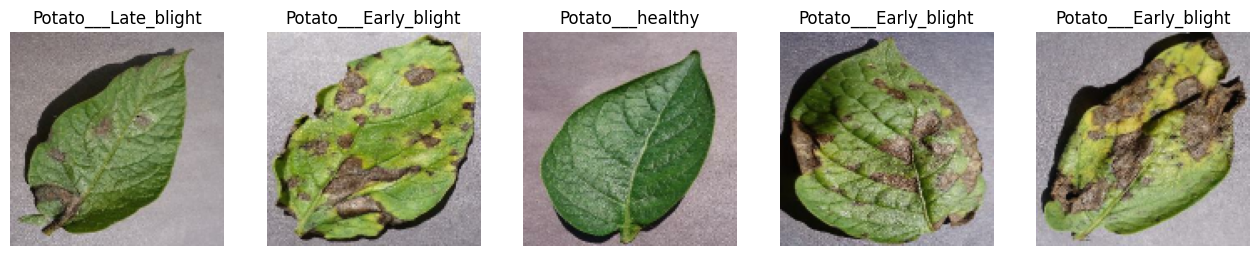

In [5]:
import matplotlib.pyplot as plt

# Get a batch of images from the dataset
class_names = train_ds.class_names
for images, labels in train_ds.take(1):  # Take 1 batch
    # Plot 5 images from this batch
    plt.figure(figsize=(16, 16))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')
    plt.show()


In [6]:
len(train_ds)

54

In [7]:
len(val_ds)

14

# Optimize performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Data augmentation

In [9]:
from tensorflow.keras import layers, models

# Define data augmentation block
data_augmentation = models.Sequential([
    layers.Resizing(128, 128),         # Resize
    layers.Rescaling(1./255),          # Normalize
    layers.RandomFlip("horizontal"),   # Randomly flip images horizontally
    layers.RandomRotation(0.1),        # Random rotation by 10%
    layers.RandomZoom(0.1),            # Random zoom in/out
    layers.RandomContrast(0.1)         # Adjust contrast randomly
])


# Model

In [10]:
from tensorflow.keras import layers, models

model = models.Sequential([
    data_augmentation,  # Data Augmentation (Resize, Rescale, etc.)

    # First Conv Block (with input shape!)
    layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),


    # 2nd Conv Block
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout after Conv Block

    # 3rd Conv Block
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Dropout after Conv Block

    # 4th Conv Block
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),  # Dropout after Conv Block

    layers.Flatten(),

    # Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout before the last Dense Layer

    # Output Layer (Softmax for 3 classes)
    layers.Dense(3, activation='softmax')  # 3 output classes
])

model.build(input_shape=(None, 128, 128, 3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,835 (2.64 MB)

 Trainable params: 692,835 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer is generally a good choice
    loss='sparse_categorical_crossentropy',  # Using sparse categorical crossentropy for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)


# Train the model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with GPU and EarlyStopping callback
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,                # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=30,               # Number of epochs to train the model
        batch_size=32,           # Batch size (already defined in the dataset)
        verbose=1,               # Display training progress
        callbacks=[early_stopping]  # Add the early stopping callback here
    )


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9654 - loss: 0.1039 - val_accuracy: 0.9397 - val_loss: 0.1820
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9596 - loss: 0.1001 - val_accuracy: 0.9559 - val_loss: 0.1389
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9682 - loss: 0.1025 - val_accuracy: 0.9490 - val_loss: 0.1460
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9751 - loss: 0.0809 - val_accuracy: 0.9652 - val_loss: 0.1161
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9591 - loss: 0.0976 - val_accuracy: 0.9652 - val_loss: 0.1160
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9628 - loss: 0.1039 - val_accuracy: 0.9814 - val_loss: 0.0795
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9550 - loss: 0.1356 - val_accuracy: 0.9513 - val_loss: 0.1118
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9666 - loss: 0.0809 - val_accuracy: 0.9698 - v

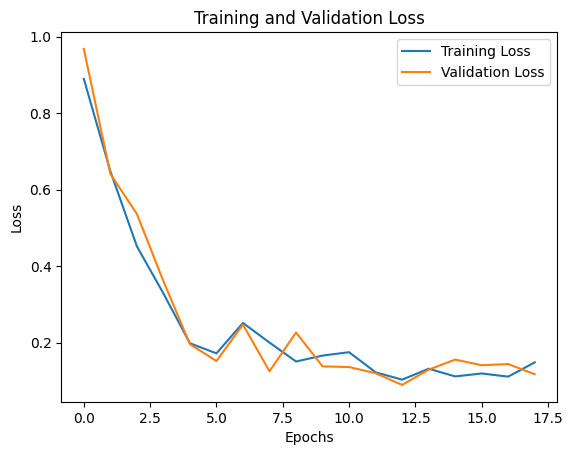

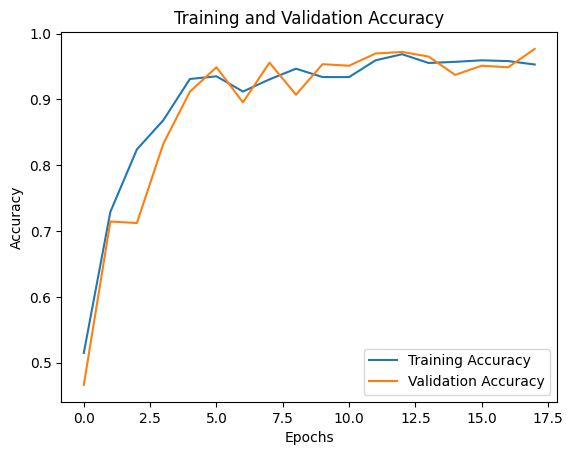

In [14]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history

# Plot training and validation loss
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Evaluate Model Performance on Test Data:

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9827 - loss: 0.0875
Validation Loss: 0.0795
Validation Accuracy: 0.9814


# Make Predictiom

In [24]:
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)

    plt.figure(figsize=(14, 14))
    for i in range(16):  # Show 16 images
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[labels[i]]}\nPrediction: {class_names[preds[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Save the Model

In [25]:
# Save the model
model.save("/content/drive/MyDrive/plant/potato_model.h5")


# Later you can load it with:


# from tensorflow.keras.models import load_model
# model = load_model("/content/drive/MyDrive/plant/potato_model.h5")
